# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [93]:
CORPUS_NAME = 'genia'
MODEL_NAME = CORPUS_NAME + '_pmc_20k'
MODEL_SPEC = '_l7_min10'
FREQ_THRESHOLD = 5

INCLUDE_MESH_TERMS = True
FILTER_STOP_WORDS = True
FILTER_PUNCTUATION = True

In [3]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model', flush=True)
model = ngramcounting.NgramModel.load_model(MODEL_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:17<00:00, 91.53it/s] 


## Question 1: How strong is the association in regular concepts?

In [4]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [5]:
len(cont_concepts)

22620

In [6]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [7]:
if INCLUDE_MESH_TERMS:
    concept_bigrams.update(
    {bigram for concept in dataio.load_mesh_terms()
     for bigram in nltk.bigrams(concept)}
    )
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in punct or bg[1] in punct)}

Loading MeSH terms ...


In [8]:
import pandas as pd
import math

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'tc': [], 'dice': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    dice = conceptstats.term_coherence(bigram, model) / math.log10(count)
    data_dict['dice'].append(dice)
    combo = pmi + math.log10(count) * 2
    data_dict['combo'].append(combo)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [9]:
sum(data.freq)

149886421

In [10]:
# number of bigram types:
print('Outside:', len(data[data['in_concept'] == False]))
print('Inside:', len(data[data['in_concept'] == True]))

Outside: 318434
Inside: 18094


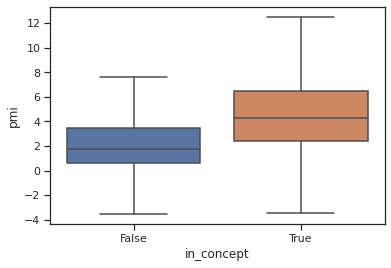

In [11]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

In [12]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=-3.57, lower quartile=0.58, median=1.63, upper quartile=3.14, upper whisker=7.62}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-3.45, lower quartile=2.38, median=4.22, upper quartile=6.37, upper whisker=12.52}] coordinates {};
\end{axis}


In [13]:
data[(data['in_concept'] == True)].sort_values('combo', ascending=False).head(10)
#  & (data['pmi'] < 0)

,bigram,in_concept,pmi,ll,tc,dice,combo,freq
240252,"(incontinentia, pigmenti)",True,15.054784,1734.855614,1.685572,0.972973,18.519571,54
297431,"(polymyalgia, rheumatica)",True,14.990419,1786.570307,1.673479,0.957265,18.486795,56
143575,"(talimogene, laherparepvec)",True,15.036366,1659.168732,1.622403,0.945455,18.468373,52
240737,"(pyoderma, gangrenosum)",True,15.052762,1629.079649,1.612705,0.944444,18.467902,51
929,"(cubitus, interruptus)",True,14.913463,1864.256586,1.671684,0.944000,18.455167,59
5305,"(pseudoxanthoma, elasticum)",True,14.522014,2694.768711,1.830101,0.941176,18.410980,88
102426,"(ossificans, progressiva)",True,14.361392,3152.624399,1.898384,0.941176,18.395459,104
209545,"(epidermolysis, bullosa)",True,14.359177,3144.712275,1.898384,0.941176,18.393243,104
35364,"(denileukin, diftitox)",True,13.821824,5437.171620,2.170331,0.956298,18.360849,186
231310,"(withania, somnifera)",True,14.659424,2126.663171,1.637169,0.890323,18.337122,69


In [14]:
import re
csv_string = data[(data['in_concept'] == False)  & (data['pmi'] < 4)].sort_values('pmi', ascending=False).tail(10).to_csv(sep='&')
csv_string = csv_string.replace('&True', '')
csv_string = csv_string.replace("('", '')
csv_string = csv_string.replace("')", '')
csv_string = csv_string.replace("', '", ' ')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

	& bigram	& in_concept	& pmi	& ll	& tc	& dice	& combo	& freq\\
, .	& False	& -6.8650215877303555	& 430319.47615140676	& 7.590718053416734e-05	& 3.246037749334413e-05	& -2.1881086005211463	& 218\\
the the	& False	& -6.916969625708372	& 375788.45606728643	& 6.618040127899421e-05	& 2.9313473589936895e-05	& -2.401612475970003	& 181\\
, ,	& False	& -6.948818044623012	& 630376.804524228	& 9.043613383983566e-05	& 3.668238942552237e-05	& -2.0180523417261753	& 292\\
, '.	& False	& -7.019510205574813	& 197579.12458575517	& 3.631627797678631e-05	& 1.8772968235482875e-05	& -3.1505133030876773	& 86\\
and and	& False	& -7.115332702843922	& 283714.877245374	& 4.2718637987426384e-05	& 2.084631186864292e-05	& -3.016896657503559	& 112\\
of', 	& False	& -7.163394381543096	& 239512.22992143035	& 3.423159039091382e-05	& 1.7516551925142043e-05	& -3.2549093626644465	& 90\\
, ',	& False	& -7.349456153805769	& 289763.67022933066	& 3.0192241946308086e-05	& 1.5449588165478134e-05	& -3.4409711349271195	& 90\\
in 

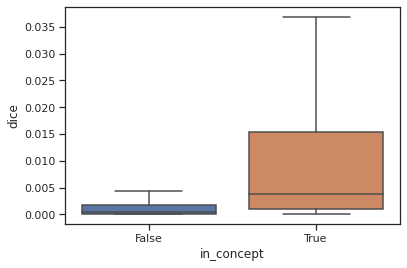

In [15]:
sns.boxplot(x='in_concept', y='dice', data=data, showfliers=False)

In [16]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'll', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=66.37, median=223.71, upper quartile=567.24, upper whisker=1870.20}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=347.97, median=892.62, upper quartile=2025.75, upper whisker=7535.21}] coordinates {};
\end{axis}


In [17]:
data[(data['in_concept'] == True)].sort_values('ll', ascending=False).head(10)

,bigram,in_concept,pmi,ll,tc,dice,combo,freq
217270,"(transcription, factor)",True,5.718575,851832.508936,1.640381,0.333554,15.554363,82774
335144,"(breast, cancer)",True,5.539699,800909.647173,1.080325,0.220822,15.324255,78033
141809,"(stem, cell)",True,4.187006,796708.274678,0.339493,0.067862,14.192332,100615
61179,"(cell, line)",True,3.994336,726152.747022,0.342521,0.068372,14.013688,102253
187428,"(bone, marrow)",True,7.597768,661622.340669,2.857717,0.616065,16.875086,43517
190740,"(gene, expression)",True,3.953480,641912.307566,0.800152,0.159714,13.973307,102309
208365,"(growth, factor)",True,5.377006,621762.793396,1.234093,0.255913,15.021630,66422
9696,"(immune, response)",True,5.228474,600087.709653,1.128833,0.234071,14.873673,66466
171935,"(western, blot)",True,8.112253,463824.937120,3.026239,0.678592,17.031429,28813
278786,"(flow, cytometry)",True,8.333830,455767.669031,3.143268,0.709978,17.188380,26747


In [18]:
# we can perform t-tests etc.
import pingouin

In [19]:
t_test_result = pingouin.ttest(list(data[data['in_concept'] == True]['pmi']),
               list(data[data['in_concept'] == False]['pmi']),
               correction=True)

/home/kasper/.local/lib/python3.6/site-packages/pingouin/bayesian.py:151: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


In [20]:
t_test_result

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,102.145,19516.52,two-sided,0.0,"[2.28, 2.37]",0.927,inf,1.0


In [21]:
pingouin.compute_effsize_from_t(t_test_result['T'][0],
                                nx=len(list(data[data['in_concept'] == True]['pmi'])),
                                ny=len(list(data[data['in_concept'] == False]['pmi'])),
                                eftype='cles')

0.7095243561772798

In [22]:
pingouin.mwu(list(data[data['in_concept'] == True]['ll']),
             list(data[data['in_concept'] == False]['ll']))

MemoryError: Unable to allocate 42.9 GiB for an array with shape (18094, 318434) and data type float64

In [ ]:
sns.lmplot('dice', 'tc', data)

In [ ]:
data.sort_values('tc')[(data['pmi'] > 8)]

Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [23]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)


Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [24]:
# extra dc's: skipgrams from CC's which are also CC's and hence a valid DC
if True:
    extra_dcs = set()
    for concept in cont_concepts:
        count = 0
        for sg in set(ngramcounting.make_skipgrams(concept)).difference(
            ngramcounting.make_ngrams(concept)):
            if sg in cont_concepts:
                print(concept, '-->', sg)
                extra_dcs.add(sg)
    disc_concepts.update(extra_dcs)

('human', 't-lymphocyte', 'gata-3', 'factor') --> ('human', 'factor')
('human', 't-lymphocyte', 'gata-3', 'factor') --> ('human', 'gata-3')
('t-cell', 'receptor', '(', 'tcr', ')', 'gene') --> ('tcr', 'gene')
('t-cell', 'receptor', '(', 'tcr', ')', 'gene') --> ('t-cell', 'gene')
('t-cell', 'receptor', '(', 'tcr', ')', 'gene') --> ('t-cell', 'receptor', 'gene')
('ifn-gamma', 'cytoplasmic', 'mrna') --> ('ifn-gamma', 'mrna')
('mitogen-activated', 'protein', 'kinase', 'family') --> ('mitogen-activated', 'kinase')
('mitogen-activated', 'protein', 'kinase', 'family') --> ('protein', 'family')
('signal', 'transducer', 'and', 'activation', 'of', 'transcription', '(', 'stat', ')', 'transcription', 'factor') --> ('stat', 'transcription')
('signal', 'transducer', 'and', 'activation', 'of', 'transcription', '(', 'stat', ')', 'transcription', 'factor') --> ('stat', 'transcription', 'factor')
('signal', 'transducer', 'and', 'activation', 'of', 'transcription', '(', 'stat', ')', 'transcription', 'fact

('stat', '(', 'signal', 'transducer', 'and', 'activator', 'of', 'transcription', ')', '6') --> ('stat', '6')
('stat', '(', 'signal', 'transducer', 'and', 'activator', 'of', 'transcription', ')', '6') --> ('stat', 'transcription')
('surface', 'ig', '(', 'sig', ')', 'receptor') --> ('surface', 'receptor')
('surface', 'ig', '(', 'sig', ')', 'receptor') --> ('ig', 'receptor')
('nfil-2b', 'nuclear', 'protein', 'complex') --> ('nuclear', 'complex')
('camp', '-dependent', 'intracellular', 'signaling', 'pathway') --> ('camp', '-dependent', 'signaling', 'pathway')
('camp', '-dependent', 'intracellular', 'signaling', 'pathway') --> ('intracellular', 'pathway')
('camp', '-dependent', 'intracellular', 'signaling', 'pathway') --> ('camp', 'signaling', 'pathway')
('c-fos', 'promoter', 'sis-inducible', 'element', 'probe') --> ('promoter', 'element')
('nf-kappa', 'b', 'dna', 'binding', 'protein') --> ('nf-kappa', 'b', 'binding', 'protein')
('nf-kappa', 'b', 'dna', 'binding', 'protein') --> ('nf-kappa'

('myelin', 'basic', 'protein', '(', 'mbp', ')', '-', 'specific', 'human', 't', 'cell', 'line') --> ('human', 'cell')
('myelin', 'basic', 'protein', '(', 'mbp', ')', '-', 'specific', 'human', 't', 'cell', 'line') --> ('human', 'cell', 'line')
('lymphoid-restricted', ',', 'octamer', 'site-mediated', 'immunoglobulin', 'gene', 'promoter', 'activity') --> ('immunoglobulin', 'promoter')
('lymphoid-restricted', ',', 'octamer', 'site-mediated', 'immunoglobulin', 'gene', 'promoter', 'activity') --> ('immunoglobulin', 'promoter', 'activity')
('lymphoid-restricted', ',', 'octamer', 'site-mediated', 'immunoglobulin', 'gene', 'promoter', 'activity') --> ('lymphoid-restricted', 'gene')
('camp', 'response', 'element-binding', 'protein', '(', 'creb', ')', 'factor') --> ('protein', 'factor')
('cem', 'c1', 'cell') --> ('cem', 'cell')
('epstein-barr', '(', 'ebv', ')', '-transformed', 'b', 'cell', 'line') --> ('ebv', '-transformed', 'cell')
('epstein-barr', '(', 'ebv', ')', '-transformed', 'b', 'cell', 'l

('inflammatory', 'effector', 'gene', 'product') --> ('inflammatory', 'gene')
('inflammatory', 'effector', 'gene', 'product') --> ('inflammatory', 'gene', 'product')
('pkc', 'enzymatic', 'activity') --> ('pkc', 'activity')
('ig', 'heavy', 'chain', 'class', 'switching') --> ('ig', 'class', 'switching')
('drosophila', 'schneider', 'cell') --> ('drosophila', 'cell')
('invariant', '(', 'ii', ')', 'chain') --> ('ii', 'chain')
('invariant', '(', 'ii', ')', 'chain') --> ('invariant', 'chain')
('tumour', 'necrosis', 'factor', '(', 'tnf', ')', 'transcript') --> ('tnf', 'transcript')
('stimulate', 'and', 'unstimulated', 't', 'cell') --> ('stimulate', 'cell')
('stimulate', 'and', 'unstimulated', 't', 'cell') --> ('unstimulated', 'cell')
('stimulate', 'and', 'unstimulated', 't', 'cell') --> ('stimulate', 't', 'cell')
('signal', 'transducer', 'and', 'activator', 'of', 'transcription', '1') --> ('signal', '1')
('stat', 'transcription', 'factor', 'family') --> ('stat', 'factor')
('stat', 'transcriptio

('nuclear', 'factor-kappab', '(', 'nf-kappab', ')', '/', 'rel', 'family', 'member') --> ('nuclear', 'nf-kappab')
('nuclear', 'factor-kappab', '(', 'nf-kappab', ')', '/', 'rel', 'family', 'member') --> ('nf-kappab', 'family', 'member')
('nuclear', 'factor-kappab', '(', 'nf-kappab', ')', '/', 'rel', 'family', 'member') --> ('nf-kappab', 'family')
('untreated', 'hl-60', 'cell') --> ('untreated', 'cell')
('activate', 'endothelial', 'cell') --> ('activate', 'cell')
('nf-kappa', 'b', 'dependent', 'reporter', 'gene', 'construct') --> ('reporter', 'construct')
('nf-kappa', 'b', 'dependent', 'reporter', 'gene', 'construct') --> ('nf-kappa', 'b', 'gene')
('tyrosine', '-protein', 'kinase', '-specific', 'inhibitor') --> ('tyrosine', 'kinase')
('tyrosine', '-protein', 'kinase', '-specific', 'inhibitor') --> ('tyrosine', 'kinase', 'inhibitor')
('cat', 'gene', 'expression') --> ('cat', 'expression')
('human', 'b', 'cell', 'line') --> ('b', 'line')
('human', 'b', 'cell', 'line') --> ('human', 'cell', 

('polyomavirus', 'enhancer-binding', 'protein', '2/core-binding', 'factor', '(', 'pebp2/cbf', ')', 'family', ',') --> ('protein', 'factor')
('polyomavirus', 'enhancer-binding', 'protein', '2/core-binding', 'factor', '(', 'pebp2/cbf', ')', 'family', ',') --> ('factor', 'family')
('polyomavirus', 'enhancer-binding', 'protein', '2/core-binding', 'factor', '(', 'pebp2/cbf', ')', 'family', ',') --> ('pebp2/cbf', 'family')
('polyomavirus', 'enhancer-binding', 'protein', '2/core-binding', 'factor', '(', 'pebp2/cbf', ')', 'family', ',') --> ('protein', 'family')
('purify', 'quiescent', 'human', 'blood', 't', 'lymphocyte') --> ('purify', 't', 'lymphocyte')
('purify', 'quiescent', 'human', 'blood', 't', 'lymphocyte') --> ('human', 't')
('purify', 'quiescent', 'human', 'blood', 't', 'lymphocyte') --> ('blood', 'lymphocyte')
('purify', 'quiescent', 'human', 'blood', 't', 'lymphocyte') --> ('human', 't', 'lymphocyte')
('purify', 'quiescent', 'human', 'blood', 't', 'lymphocyte') --> ('human', 'lymph

('type', 'ii', 'il-1', 'receptor') --> ('ii', 'receptor')
('lt', 'promoter', '(', 'lt-293', ')', 'cat', 'construct') --> ('promoter', 'construct')
('phytohemagglutinin', '-induced', 'peripheral', 'blood', 'mononuclear', 'cell', 'proliferation') --> ('peripheral', 'blood', 'cell')
('phytohemagglutinin', '-induced', 'peripheral', 'blood', 'mononuclear', 'cell', 'proliferation') --> ('blood', 'cell')
('t-cell-specific', 'elf-1', 'factor') --> ('t-cell-specific', 'factor')
('interferon-responsive', 'factor', '(', 'irf', ')', 'binding', 'site') --> ('factor', 'binding', 'site')
('early', 'g1', 'protein') --> ('early', 'protein')
('human', 'eotaxin', 'gene') --> ('human', 'gene')
('human', 'il-5', 'receptor') --> ('human', 'receptor')
('dominant', 'negative', 'hlh', 'factor') --> ('negative', 'factor')
('mouse', 'tis11', 'gene') --> ('mouse', 'gene')
('transcription', 'and', 'transformation', 'activity') --> ('transcription', 'activity')
('human', 't-cell', 'lymphotropic', 'virus', 'type', '

('estrogen', 'receptor', 'positive', '(', 'er+', ':', 'mcf-7', ')', 'and', 'negative', '(', 'er-', ':', 'mda-mb-231', ')', 'human', 'breast', 'cancer', 'cell', 'line') --> ('er-', 'cell')
('estrogen', 'receptor', 'positive', '(', 'er+', ':', 'mcf-7', ')', 'and', 'negative', '(', 'er-', ':', 'mda-mb-231', ')', 'human', 'breast', 'cancer', 'cell', 'line') --> ('positive', 'cell')
('estrogen', 'receptor', 'positive', '(', 'er+', ':', 'mcf-7', ')', 'and', 'negative', '(', 'er-', ':', 'mda-mb-231', ')', 'human', 'breast', 'cancer', 'cell', 'line') --> ('human', 'cell')
('estrogen', 'receptor', 'positive', '(', 'er+', ':', 'mcf-7', ')', 'and', 'negative', '(', 'er-', ':', 'mda-mb-231', ')', 'human', 'breast', 'cancer', 'cell', 'line') --> ('human', 'cell', 'line')
('epstein-barr', 'virus', '(', 'ebv', ')', 'genome') --> ('ebv', 'genome')
('dnase', 'i', 'footprinting', 'analysis') --> ('dnase', 'footprinting')
('retinoic-acid', 'receptor', 'type', 'alpha') --> ('receptor', 'alpha')
('major', 

('htlv-1', 'infected', 'human', 't', 'cell') --> ('infected', 't', 'cell')
('amino', 'acid', 'sequence', 'identity') --> ('amino', 'acid', 'identity')
('primary', 't', 'cell', 'response') --> ('primary', 'cell')
('interleukin', '2', 'receptor', 'alpha', 'chain', '/cd25', 'promoter') --> ('receptor', 'promoter')
('interleukin', '2', 'receptor', 'alpha', 'chain', '/cd25', 'promoter') --> ('interleukin', '2', 'promoter')
('cd23', 'mrna', 'transcription') --> ('cd23', 'transcription')
('hiv-1', 'ap-1', 'dna', 'recognition', 'sequence') --> ('ap-1', 'sequence')
('hiv-1', 'ap-1', 'dna', 'recognition', 'sequence') --> ('dna', 'sequence')
('nonstimulated', 'b', 'cell') --> ('nonstimulated', 'cell')
('cis-acting', 'negative', 'regulatory', 'element') --> ('cis-acting', 'regulatory', 'element')
('cis-acting', 'negative', 'regulatory', 'element') --> ('cis-acting', 'element')
('cis-acting', 'negative', 'regulatory', 'element') --> ('negative', 'element')
('human', 'aml1', 'gene') --> ('human', 'g

('helix-loop-helix', '(', 'hlh', ')', 'protein') --> ('hlh', 'protein')
('helix-loop-helix', '(', 'hlh', ')', 'protein') --> ('helix-loop-helix', 'protein')
('human', 't-cell', 'leukemia', 'virus', 'type', '1', 'posttranscriptional', 'trans-activator') --> ('human', 't-cell', 'type')
('human', 't-cell', 'leukemia', 'virus', 'type', '1', 'posttranscriptional', 'trans-activator') --> ('human', 'leukemia')
('human', 't-cell', 'leukemia', 'virus', 'type', '1', 'posttranscriptional', 'trans-activator') --> ('t-cell', 'trans-activator')
('human', 't-cell', 'leukemia', 'virus', 'type', '1', 'posttranscriptional', 'trans-activator') --> ('t-cell', 'type')
('early', 'erythroid', 'progenitor', 'cell') --> ('erythroid', 'cell')
('type', 'ii', 'ifn', 'receptor') --> ('type', 'ii', 'receptor')
('type', 'ii', 'ifn', 'receptor') --> ('ii', 'receptor')
('htlv-i', '-transformed', 'peripheral', 'blood', 'mononuclear', 'cell') --> ('htlv-i', '-transformed', 'cell')
('htlv-i', '-transformed', 'peripheral'

In [25]:
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

In [26]:
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in punct or bg[1] in punct)}

In [27]:
import pandas as pd
import nltk

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'tc': [], 'dice': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        continue
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    data_dict['type'].append(bigram_type)
    
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(math.log10(count))
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    dice = tc / math.log10(count)
    data_dict['dice'].append(dice)
    combo = pmi + math.log10(count)
    data_dict['combo'].append(combo)


data = pd.DataFrame(data_dict)

In [28]:
data

,bigram,type,pmi,ll,tc,dice,combo,freq
0,"(and, dead)",neither,1.207796,347.018056,0.000306,0.000122,6.236892,2.514548
1,"(arbor, ,)",neither,3.149269,10704.456693,0.001520,0.000465,9.684551,3.267641
2,"(homocysteine, in)",neither,0.893076,36.855804,0.000044,0.000025,4.419932,1.763428
3,"(the, periosteum)",neither,2.854272,414.025782,0.000059,0.000030,6.791238,1.968483
4,"(prostaglandin, .)",neither,-1.032416,153.477473,0.000069,0.000035,2.932127,1.982271
...,...,...,...,...,...,...,...,...
336449,"(post-test, ))",neither,2.139013,282.493403,0.000115,0.000057,6.189624,2.025306
336450,"(silva, et)",neither,3.162835,848.529753,0.001650,0.000725,7.715759,2.276462
336451,"(positive, regulation)",both,3.189288,3877.705026,0.025030,0.008524,9.062316,2.936514
336452,"([, 69)",neither,3.915968,28073.537427,0.043044,0.011744,11.246379,3.665206


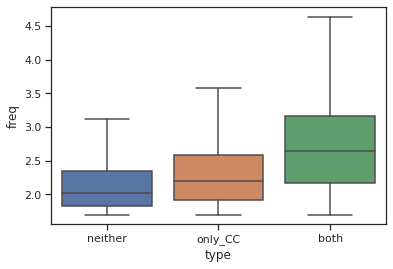

In [29]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [30]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3}, xticklabels={neither, both, only_CC}]
\addplot+ [boxplot prepared={lower whisker=-3.58, lower quartile=0.58, median=1.63, upper quartile=3.14, upper whisker=7.62}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-2.30, lower quartile=1.81, median=3.16, upper quartile=4.56, upper whisker=8.83}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-3.45, lower quartile=2.49, median=4.39, upper quartile=6.62, upper whisker=12.92}] coordinates {};
\end{axis}


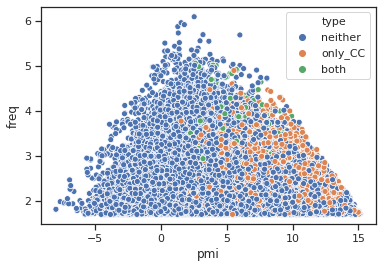

In [31]:
sns.scatterplot(x='pmi', y='freq', hue='type', data=data)

In [ ]:
pingouin.homoscedasticity(data, 'pmi', 'type')

In [ ]:
pingouin.qqplot(list(data[data['type'] == 'only_CC']['pmi']))

In [ ]:
pingouin.welch_anova(data, 'dice', 'type')

In [ ]:
pairwise = pingouin.pairwise_gameshowell(data, 'pmi', 'type', effsize='CLES')#.to_csv(sep='&')

In [ ]:
pairwise

In [ ]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

In [ ]:
pingouin.compute_effsize_from_t(86.845, nx=len(list(data[data['type'] == 'neither']['pmi'])),
                                ny=len(list(data[data['type'] == 'only_CC']['pmi'])), eftype='cles')

In [ ]:
data[data['type'] == 'both'].sort_values('pmi', ascending=False).head(20)

In [ ]:
{bg for bg in data[data['type'] == 'only_CC']['bigram'] if bg[0] == 'bone'}

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('type', 'll', data))

In [ ]:
# However, notice that
len(data[data['type'] == 'only_DC'])

In [ ]:
# compared to e.g.
len(data[data['type'] == 'both'])

## Question 3: What is the association across the gap?

In [96]:
from collections import defaultdict
from itertools import product

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    spanned_tokens = dc.get_spanned_tokens()
    non_dc_tokens = set(spanned_tokens).difference(tokens)
    for t in non_dc_tokens:
        if t.mapped_pos() == 'c':
            cc = t
            break
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)

        else:
            cont_bigrams[bigram].append(dc)

In [97]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'tc': [], 'combo': [], 'type': [], 'in_concept': []}

all_bigrams = set.union(set(gap_bigrams.keys()), set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    count = model.freq(bigram)
    data_dict['freq'].append(math.log10(count))

    contingency_table = model.contingency_table(bigram[0], bigram[1], smoothing=1)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    combo = pmi + math.log10(count)
    data_dict['combo'].append(combo)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    elif bigram in cont_bigrams:
        type_ = 'only_cont'
    else:
        type_ = 'weird'

    data_dict['type'].append(type_)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

In [98]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [99]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


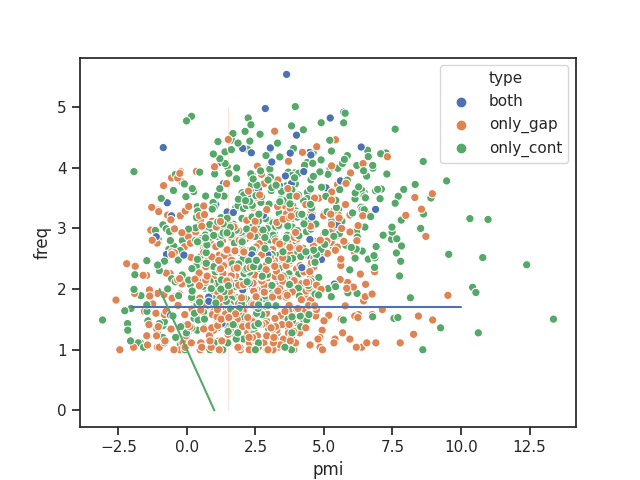

In [104]:
sns.scatterplot(x='pmi', y='freq', hue='type', data=data)
sns.lineplot(x=[-2, 10], y=[1.7, 1.7])
sns.lineplot(x=[1.5, 1.5], y=[0, 5])
sns.lineplot(x=[-1, 0, 1], y=[2 ,1, 0])

In [94]:
math.log10(50)

1.6989700043360187

In [80]:
data[data['combo'] < 1]

,bigram,freq,pmi,ll,tc,combo,type,in_concept
29,"(cytotoxic, activation)",1.041393,-1.079630,20.761362,0.000065,-0.038237,only_gap,False
70,"(a, epstein-barr)",1.579784,-0.824753,36.073989,0.000036,0.755031,only_gap,False
88,"(b, transcript)",1.113943,-1.695787,77.251206,0.000066,-0.581843,only_cont,True
110,"(mouse, sequence)",1.929419,-1.072185,146.487794,0.000476,0.857234,only_gap,False
162,"(alpha, a)",1.892095,-1.678870,428.172794,0.000087,0.213224,only_cont,False
212,"(nf-kappab, protein)",1.204120,-0.882641,18.224092,0.000056,0.321479,only_cont,True
219,"(b, element)",1.230449,-1.464782,67.122507,0.000096,-0.234333,only_gap,True
238,"(megakaryocyte, cell)",1.041393,-1.008722,17.785708,0.000008,0.032671,only_gap,False
249,"(camp, activity)",1.113943,-0.262674,1.057826,0.000095,0.851270,only_gap,False
253,"(il-2, protein)",1.361728,-1.108076,44.290515,0.000091,0.253652,only_gap,True


In [35]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3}, xticklabels={only_gap, both, only_cont}]
\addplot+ [boxplot prepared={lower whisker=-2.59, lower quartile=1.19, median=2.66, upper quartile=4.01, upper whisker=7.98}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.12, lower quartile=1.77, median=2.91, upper quartile=4.42, upper whisker=6.88}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.93, lower quartile=1.34, median=2.62, upper quartile=4.36, upper whisker=8.90}] coordinates {};
\end{axis}


In [36]:
len(data[data['type'] == 'only_gap'])

402

In [ ]:
pingouin.homoscedasticity(data, 'combo', 'type')

In [ ]:
pingouin.welch_anova(data, 'combo', 'type')

In [ ]:
pairwise = pingouin.pairwise_gameshowell(data, 'combo', 'type', effsize='cles')

In [ ]:
pairwise

In [ ]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

In [ ]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

## Question 4: What is the full-term unithood?

In [ ]:
all_concepts = disc_concepts.union(cont_concepts)

In [ ]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [ ]:
data.sort_values('tc', ascending=False).head(50)

In [ ]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

In [ ]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

In [ ]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, FREQ_THRESHOLD):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi'].append(conceptstats.length_normalized_pmi(ngram, model) * (len(ngram) - 1))
        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
print(utils.prepare_comparable_latex_boxplots('len', 'pmi_nl', data))